# Reddit API using PRAW ( Python Reddit API Wrapper ) 

External Reference
<br>https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/
<br>https://www.kaggle.com/khsamaha/reddit-vaccine-myths-eda-and-text-analysis
<br>https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/

We will scrape data from the subreddit <b>politics</b> and try to find out what kind of news attracts the crowd

## What question we will try to answer - 
<br>Which kind of news gets maximum attention?


## What kind of insights we will try to find - 
<br>1. Who is the top author
<br>2. Top news provider
<br>3. Most used words across all news source
<br>4. Overall sentiment of the news

### Importing modules 

In [20]:
import praw,requests,math, itertools,collections, wordcloud
import pandas as pd
import numpy as np
from IPython import display
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set(style='darkgrid', context='talk', palette='Dark2')

### Configuring PRAW 

In [ ]:
reddit = praw.Reddit(
    client_id='<--xxx-->', 
    client_secret='<--xxx-->', 
    user_agent='<--xxx-->',
    username='<--xxx-->',
    password='<--xxx-->')

### Displaying Reddit Username 

In [3]:
print(reddit.user.me())

A_Beyonder


### Finding results from a subreddit
We use the query <b> reddit.subreddit('<-- Subreddit Name -->').hot(limit = 5) </b> <br>
<b>.hot</b> indicates, in terms of reddit, the trending posts<br>
Other alternatives for hot are new ( latest posts ) and rising ( posts which getting more activity ) <br>
(limit = 5) indicates we are selecting 5 posts

In [4]:
rising_posts = reddit.subreddit('quotes').rising(limit=3)
for post in rising_posts:
    print(post.title,end="\n\n") #printing individual posts

If you have health you have hope, if you have hope you have everything

"May your choices reflect your hopes, not your fears." ~ Nelson Mandela

"Success isn't always about greatness. It's about consistency. Consistent hard work leads to success. Greatness will come." Dwayne Johnson



#### To get all the methods we have we can use dir on the posts 

In [4]:
hot_posts = reddit.subreddit('quotes').hot(limit=1)
for post in hot_posts:
    print(dir(post))

['STR_FIELD', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_chunk', '_comments_by_id', '_fetch', '_fetch_data', '_fetch_info', '_fetched', '_kind', '_reddit', '_reset_attributes', '_safely_add_arguments', '_url_parts', '_vote', 'all_awardings', 'allow_live_comments', 'approved_at_utc', 'approved_by', 'archived', 'author', 'author_flair_background_color', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_template_id', 'author_flair_text', 'author_flair_text_color', 'author_flair_type', 'author_fullname', 'author_is_blocked', 'author_patreon_flair', 'author_premium', 'award', 'awarders', 'banned_at_utc', 'banned_by', 'can_gild', 'can_mod_post', 'category', 'clear_

## Choosing what information we want
1. title -> We get the title of reddit post
2. selftext -> We get the content of reddit post
3. author -> We get the author of reddit post
4. ups -> We get the upvotes for the reddit post
5. downs -> We get the downvotes for the reddit post
6. num_comments -> We get the number of comments on reddit post
7. link_flair_text -> We get the tags if any on the post
8. url -> We get the url if any of the reddit post

We will store that data in pandas dataframe

In [5]:
hot_posts = reddit.subreddit('politics').hot(limit=800)

posts = []

for post in hot_posts:
    posts.append([post.title, post.score, post.id, post.author, post.url, post.num_comments, 
                  post.ups, post.downs, post.link_flair_text])

posts_df = pd.DataFrame(posts,columns=['title', 'score', 'id', 'author', 'url', 'num_comments',
                                       'upvotes','downvotes','category'])

#Separating the news provider from the link
posts_df['news_provider'] = posts_df['url'].str.split('/').str[2]

In [8]:
posts_df.head()

,title,score,id,author,url,num_comments,upvotes,downvotes,category
0,House Censures Congressman Paul Gosar and Stri...,15191,qwacbq,PoliticsModeratorBot,https://www.reddit.com/r/politics/comments/qwa...,1441,15191,0,Megathread
1,Sanders Says Deficit Concerns 'Seem to Melt Aw...,22649,qwoizo,morenewsat11,https://www.commondreams.org/news/2021/11/18/s...,726,22649,0,NaN
2,"'If You Care About Inflation,' Says Jayapal, '...",2295,qwnuhs,Fr1sk3r,https://www.commondreams.org/news/2021/11/17/i...,192,2295,0,NaN
3,Letâ€™s Stop Handing the Pentagon Blank Checks,2990,qwmkdb,montenerali,https://www.thenation.com/article/economy/pent...,205,2990,0,NaN
4,Trump and his regime committed â€” or at least...,1472,qwop3v,damselfliesreddit,https://www.salon.com/2021/11/18/and-his-regim...,288,1472,0,NaN


In [150]:
#Top 5 posts by score
posts_df.sort_values(by='score', ascending=False).head(5)

,title,score,id,author,url,num_comments,upvotes,downvotes,category,news_provider
14,FBI raids home of Lauren Boebert's ex-campaign...,62556,qw6j18,dr_durp,https://www.salon.com/2021/11/17/fbi-raids-hom...,2519,62556,0,NaN,www.salon.com
182,Teachers & parents rip school board to shreds ...,58042,qva4q4,southpawFA,https://www.lgbtqnation.com/2021/11/teachers-p...,2234,58042,0,NaN,www.lgbtqnation.com
330,Biden signs $1 trillion bipartisan infrastruct...,43808,quqy63,WeWoweewoo,https://www.cnbc.com/2021/11/15/biden-signing-...,4177,43808,0,NaN,www.cnbc.com
390,Trump ally Bannon taken into custody on contem...,36327,qui3d5,randoliof,https://apnews.com/article/steve-bannon-donald...,2108,36327,0,NaN,apnews.com
411,"Stephen Miller, Come on Down! Jan. 6 Committee...",34347,qufg0q,Baarney23,https://www.rollingstone.com/politics/politics...,1115,34347,0,NaN,www.rollingstone.com


In [4]:
len(posts_df)

728

In [5]:
def top_news_provider(news):
    """
    input: news link
    returns the top news provider and frequency
    """
    url_list = []
    for i in news:
        url_list.append(i)
    
    news_freq_dict = {}

    for url_title in range(0,len(url_list)):
        #url = url_list[url_title].split('/')[2]
        if url_list[url_title] not in news_freq_dict:
            news_freq_dict[url_list[url_title]] = 1
        news_freq_dict[url_list[url_title]] += 1
        
    news_freq_sorted = sorted(news_freq_dict.items(), key=lambda kv: kv[1], reverse=True)
    
    return news_freq_sorted

def top_author(authors):
    """
    takes author column as input
    returns top 5 authors and their posts as dataframe
    """
    all_authors = []
    authors_list = []
    all_authors.append(authors.value_counts().index)
    for i in range(0,5):
        authors_list.append(all_authors[0][i])
    author_df = posts_df.loc[posts_df['author'].isin(authors_list)]
    return authors_list,author_df 

def news_by_word(word):
    """
    returns all news article containing the specified word
    """
    word_news = posts_df.loc[(posts_df['title'].str.contains(word[0][0], case=False))]
    
    return word_news

def word_usage(title):
    """
    returns top 10 words
    """
    title_text = ""
    newline = '\n'
    top10_words = []
    
    for text in title:
        title_text += text

    for i in title_text:
        title_string = title_text.replace(newline, '')

    freq = calculate_frequencies(title_string)
    freq_sorted = sorted(freq.items(), key=lambda kv: kv[1], reverse=True)
    
    for word in range(0,10):
        top10_words.append(freq_sorted[word][0])
    
    word_news = news_by_word(freq_sorted)
    
    return top10_words,word_news,freq

def calculate_frequencies(file_contents):
    """
    function to calculate frequency of words
    """
    # Here is a list of punctuations and uninteresting words you can use to process your text
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    uninteresting_words = ["the", "a", "to", "if", "is","in","on","would","it", "of","after","and", "or", "an", "as", "i", "me", "my", \
    "we", "our", "ours", "you", "your", "yours", "he", "she", "him", "his", "her", "hers", "its", "they", "them", \
    "their", "what", "which", "who", "whom", "this", "that", "am", "are", "was", "were", "be", "been", "being", \
    "have", "has", "had", "do", "does", "did", "but", "at", "by", "with", "from", "here", "when", "where", "how", \
    "all", "any", "both", "each", "few", "more", "some", "such", "no", "nor","not", "too", "very", "can", "will", "just","for","says"]
    
    # LEARNER CODE START HERE
    frequency_dict ={}

    #word_list = file_contents.split()
    for pun in punctuations:
        file_contents.replace(pun,"")
    file_contents = file_contents.lower()
    for frequency in file_contents.split():
        if frequency in uninteresting_words:
            continue           
        elif frequency.isalpha()==True:
            if frequency not in frequency_dict:
                frequency_dict[frequency] = 1
            frequency_dict[frequency] +=1    

    return frequency_dict   

.

### Top Author 

In [6]:
author_name,author_df = top_author(posts_df.author)

In [7]:
author_name

['aslan_is_on_the_move', 'Fr1sk3r', 'UWCG', 'bologna_wallet', 'DoremusJessup']

In [9]:
author_df

,title,score,id,author,url,num_comments,upvotes,downvotes,category
2,"'If You Care About Inflation,' Says Jayapal, '...",2295,qwnuhs,Fr1sk3r,https://www.commondreams.org/news/2021/11/17/i...,192,2295,0,NaN
15,Watchdog finds no money has flowed out of agen...,5213,qwbhbh,DoremusJessup,https://thehill.com/homenews/administration/58...,221,5213,0,NaN
41,Majority Of Americans Want The Supreme Court T...,2603,qw7b6y,UWCG,https://www.huffpost.com/entry/majority-of-ame...,148,2603,0,NaN
49,Inflation is manageable. Inflation panic is ou...,406,qwgw02,bologna_wallet,https://www.washingtonpost.com/opinions/2021/1...,103,406,0,NaN
64,FBI raids Lauren Boebertâ€™s former campaign m...,895,qwa7r5,Fr1sk3r,https://www.lgbtqnation.com/2021/11/fbi-raids-...,21,895,0,NaN
69,Former Bush lawyer Richard Painter on the Jan....,5116,qvy1yn,Fr1sk3r,https://www.salon.com/2021/11/17/former-bush-l...,461,5116,0,NaN
83,Local TV Stations Love Democratsâ€™ Job-Creati...,339,qwdbu3,aslan_is_on_the_move,https://www.speaker.gov/newsroom/111621-0,27,339,0,NaN
85,"Ocasio-Cortez blasts Gosar, McCarthy over anim...",660,qw8ikx,UWCG,https://thehill.com/homenews/house/582029-ocas...,55,660,0,NaN
95,'A Damn Shame': Ohio Senate Approves 'Extreme'...,3282,qvwto5,Fr1sk3r,https://www.commondreams.org/news/2021/11/16/d...,359,3282,0,NaN
114,DeSantis Spokesperson Blames Vaccine Passport ...,556,qw4nao,bologna_wallet,https://nymag.com/intelligencer/2021/11/desant...,87,556,0,NaN


.

### Top News Provider

In [12]:
news_web = top_news_provider(posts_df.news_provider)

In [13]:
news_web

[('thehill.com', 61),
 ('www.cnn.com', 49),
 ('www.washingtonpost.com', 38),
 ('www.politico.com', 32),
 ('apnews.com', 30),
 ('www.businessinsider.com', 28),
 ('www.reuters.com', 26),
 ('www.nbcnews.com', 23),
 ('www.newsweek.com', 20),
 ('www.nytimes.com', 19),
 ('www.msnbc.com', 19),
 ('www.huffpost.com', 19),
 ('www.independent.co.uk', 18),
 ('www.commondreams.org', 17),
 ('www.theguardian.com', 14),
 ('www.salon.com', 13),
 ('abcnews.go.com', 13),
 ('www.axios.com', 12),
 ('www.lgbtqnation.com', 12),
 ('www.thedailybeast.com', 10),
 ('www.whitehouse.gov', 10),
 ('newrepublic.com', 10),
 ('www.npr.org', 9),
 ('www.rollingstone.com', 9),
 ('www.usatoday.com', 8),
 ('edition.cnn.com', 8),
 ('www.bloomberg.com', 8),
 ('www.foxnews.com', 7),
 ('www.cnbc.com', 7),
 ('www.vanityfair.com', 6),
 ('www.texastribune.org', 6),
 ('theintercept.com', 6),
 ('www.theatlantic.com', 6),
 ('www.reddit.com', 5),
 ('www.motherjones.com', 5),
 ('www.newyorker.com', 5),
 ('talkingpointsmemo.com', 5),
 (

#### thehill and cnn are the top 2 news provider over the dataset of 728  

.

### Top Words used across all news source 

In [14]:
top10_words,topword_news,freq = word_usage(posts_df.title)

In [15]:
top10_words

['biden',
 'trump',
 'infrastructure',
 'new',
 'house',
 'gop',
 'bill',
 'over',
 'about',
 'bannon']

In [16]:
def make_wordcloud(freq):
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate_from_frequencies(freq)

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

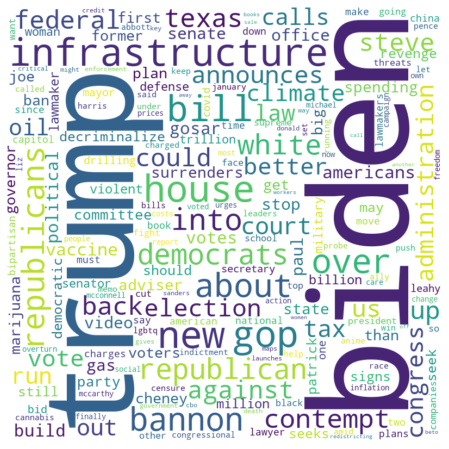

In [17]:
make_wordcloud(freq)

#### biden and trump are most talked people 

.

### Sentiment Analysis of Title

In [21]:
def get_sentiment_analysis(data):
    sia = SIA()
    results = []

    for line in data['title']:
        pol_score = sia.polarity_scores(line)
        pol_score['title'] = line
        results.append(pol_score)
    
    senti_df = pd.DataFrame.from_records(results)
    senti_df['label'] = "Neutral"
    senti_df.loc[senti_df['compound'] > 0.2, 'label'] = "Positive"
    senti_df.loc[senti_df['compound'] < -0.2, 'label'] = "Negative"
    
    fig, ax = plt.subplots(figsize=(8, 8))

    counts = senti_df.label.value_counts(normalize=True) * 100

    sns.barplot(x=counts.index, y=counts, ax=ax)

    ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
    ax.set_ylabel("Percentage")

    plt.show()
    
    merged_df = data.merge(senti_df, left_on='title', right_on='title')
    
    return merged_df

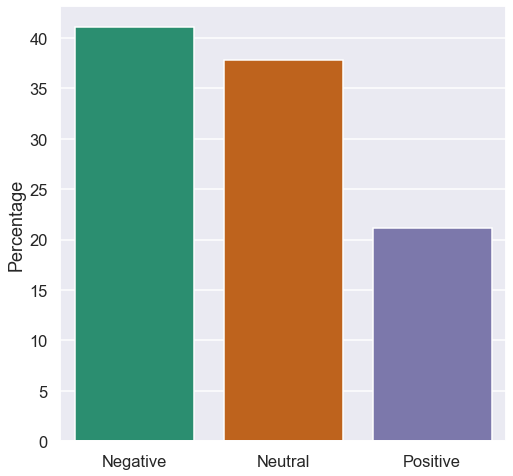

In [22]:
new_df = get_sentiment_analysis(posts_df)

In [24]:
positive_titles = new_df[new_df.label == "Positive"]
negative_titles = new_df[new_df.label == "Negative"]

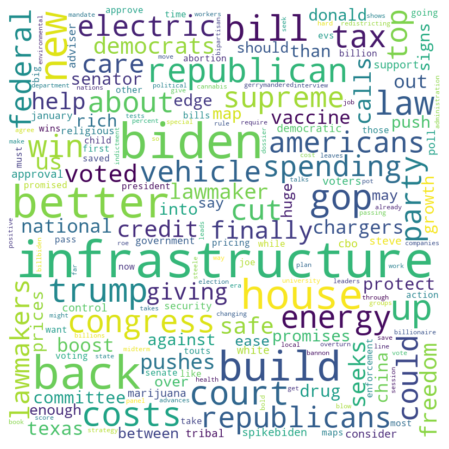

In [25]:
top10_words,topword_news,freq = word_usage(positive_titles.title)
make_wordcloud(freq)

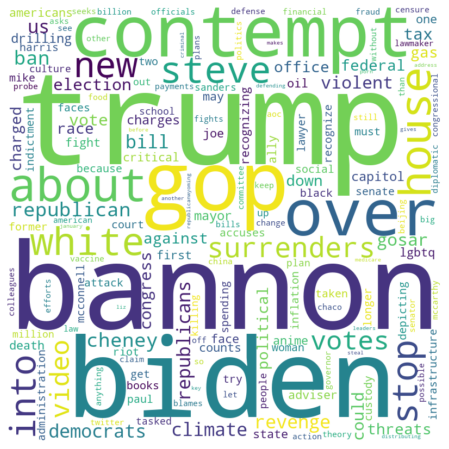

In [26]:
top10_words,topword_news,freq = word_usage(negative_titles.title)
make_wordcloud(freq)

.

## Selecting Top Scored Posts 

In [28]:
correlation = posts_df['score'].corr(posts_df['num_comments'])
correlation

0.7408177050110069

Score and Comments have strong correlation so we'll use score to get top posts

In [29]:
posts_df.score.describe()

count      728.000000
mean      1487.365385
std       5113.857026
min          0.000000
25%         45.750000
50%        150.000000
75%        775.250000
max      62556.000000
Name: score, dtype: float64

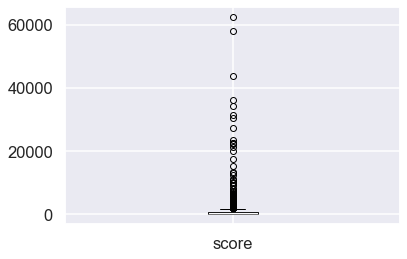

In [30]:
posts_df.boxplot(['score'])

In [59]:
top_df = posts_df.loc[(posts_df['score']>3000)]
news_web_top_df = top_news_provider(top_df.news_provider)
top10_words_top_df,topword_news_top_df,freq_top_df = word_usage(top_df.title)

In [57]:
len(top_df)

72

In [50]:
#Top news providers with top score
news_web_top_df

[('www.newsweek.com', 8),
 ('thehill.com', 6),
 ('www.businessinsider.com', 6),
 ('www.commondreams.org', 4),
 ('www.independent.co.uk', 4),
 ('www.lgbtqnation.com', 4),
 ('www.rollingstone.com', 4),
 ('www.salon.com', 3),
 ('www.vice.com', 3),
 ('www.vanityfair.com', 3),
 ('www.washingtonpost.com', 3),
 ('www.nbcnews.com', 3),
 ('www.reuters.com', 3),
 ('www.reddit.com', 2),
 ('truthout.org', 2),
 ('www.usatoday.com', 2),
 ('www.thedailybeast.com', 2),
 ('lawandcrime.com', 2),
 ('theweek.com', 2),
 ('newrepublic.com', 2),
 ('www.cnbc.com', 2),
 ('www.metrotimes.com', 2),
 ('apnews.com', 2),
 ('www.texastribune.org', 2),
 ('www.nytimes.com', 2),
 ('www.cnn.com', 2),
 ('arstechnica.com', 2)]

In [60]:
#Top news providers with top score
top10_words_top_df

['trump',
 'house',
 'biden',
 'election',
 'into',
 'gosar',
 'republican',
 'republicans',
 'paul',
 'committee']

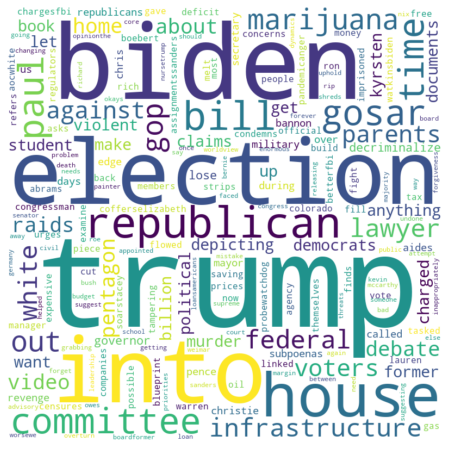

In [52]:
make_wordcloud(freq_top_df)

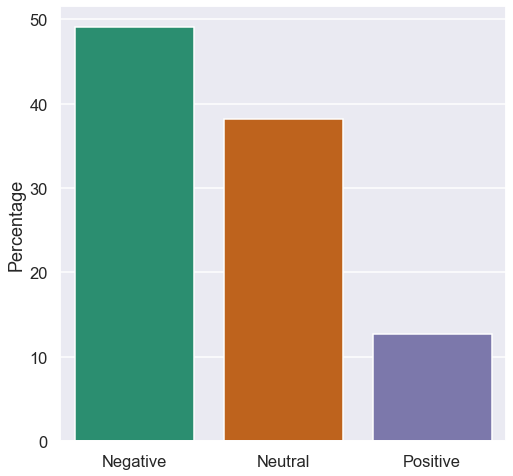

In [53]:
top_df_new = get_sentiment_analysis(top_df)

#### Top News can be generally viewed as negative news by the nltk package 

In [63]:
positive_titles = top_df_new[top_df_new.label == "Positive"]
negative_titles = top_df_new[top_df_new.label == "Negative"]
neutral_titles = top_df_new[top_df_new.label == "Neutral"]
print("Total Positive News: " + str(len(positive_titles)))
print("Total Negative News: " + str(len(negative_titles)))
print("Total Neutral News: " + str(len(neutral_titles)))

Total Positive News: 7
Total Negative News: 21
Total Neutral News: 27


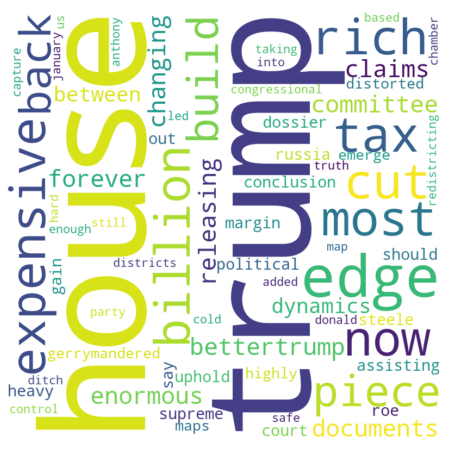

In [37]:
top10_words,topword_news,freq = word_usage(positive_titles.title)
make_wordcloud(freq)

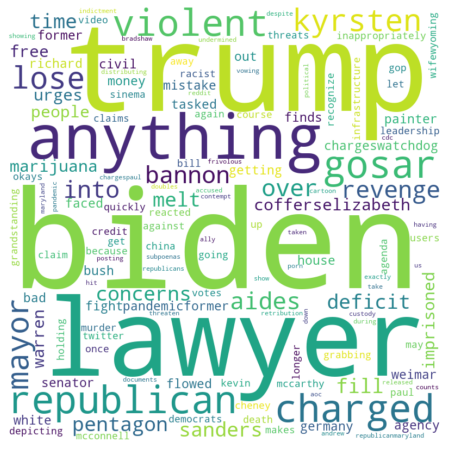

In [38]:
top10_words,topword_news,freq = word_usage(negative_titles.title)
make_wordcloud(freq)

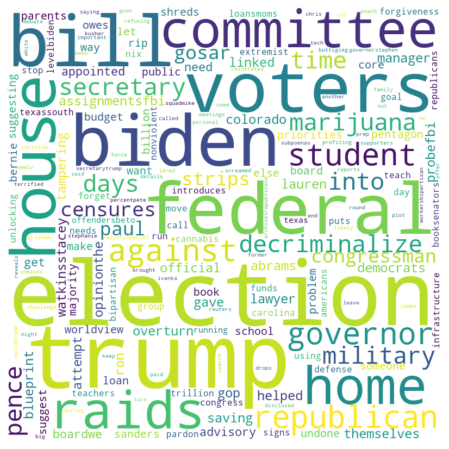

In [64]:
top10_words,topword_news,freq = word_usage(neutral_titles.title)
make_wordcloud(freq)

In [65]:
neutral_titles

,title,score,id,author,url,num_comments,upvotes,downvotes,category,news_provider,neg,neu,pos,compound,label
0,House Censures Congressman Paul Gosar and Stri...,15191,qwacbq,PoliticsModeratorBot,https://www.reddit.com/r/politics/comments/qwa...,1441,15191,0,Megathread,www.reddit.com,0.000,1.000,0.000,0.0000,Neutral
3,FBI raids home of Lauren Boebert's ex-campaign...,62556,qw6j18,dr_durp,https://www.salon.com/2021/11/17/fbi-raids-hom...,2519,62556,0,NaN,www.salon.com,0.000,1.000,0.000,0.0000,Neutral
8,FBI Raids Home of GOP Election Official Linked...,6976,qw19uh,mykl66,https://www.vice.com/en/article/93byb7/tina-pe...,231,6976,0,NaN,www.vice.com,0.000,1.000,0.000,0.0000,Neutral
10,Stacey Abrams Just Gave Democrats a Blueprint ...,7933,qvxhvs,newnemo,https://www.newsweek.com/stacey-abrams-just-ga...,595,7933,0,NaN,www.newsweek.com,0.000,1.000,0.000,0.0000,Neutral
11,The Republican lawyer who helped Trump attempt...,12527,qvw50k,DocWaterfalls,https://www.businessinsider.com/republican-law...,711,12527,0,NaN,www.businessinsider.com,0.000,1.000,0.000,0.0000,Neutral
13,We Need to Get Our Priorities Right': Bernie S...,13322,qvo6l1,Nick__________,https://www.commondreams.org/news/2021/11/16/w...,768,13322,0,NaN,www.commondreams.org,0.000,1.000,0.000,0.0000,Neutral
17,Poll: Majority of voters want Biden to make wa...,7265,qvg9zd,griffysrevenge,https://thehill.com/hilltv/what-americas-think...,2126,7265,0,NaN,thehill.com,0.000,0.909,0.091,0.0772,Neutral
18,Teachers & parents rip school board to shreds ...,58042,qva4q4,southpawFA,https://www.lgbtqnation.com/2021/11/teachers-p...,2234,58042,0,NaN,www.lgbtqnation.com,0.077,0.857,0.066,-0.1027,Neutral
19,Biden owes his core voters student loan forgiv...,5919,qvfo5p,griffysrevenge,https://theweek.com/politics/1007002/congress-...,1129,5919,0,NaN,theweek.com,0.100,0.789,0.111,0.0516,Neutral
22,Moms group puts $500 'bounty' on teachers who ...,5148,qvb96r,konorM,https://thehill.com/changing-america/enrichmen...,654,5148,0,NaN,thehill.com,0.000,1.000,0.000,0.0000,Neutral


### Analyzing co-occurance of words 

In [41]:
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx

In [42]:
title_name = posts_df['title']
title_name1 = title_name.str.replace('\d+', '')

In [43]:
# Create a sublist of lower case words for each tweet
reddit_title = [line.lower().split() for line in title_name1]
stop_words = set(stopwords.words('english'))

# Remove stop words from each tweet list of words
reddit_nsw = [[word for word in title if not word in stop_words]
              for title in reddit_title]

In [44]:
# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in reddit_nsw]

# View bigrams for the first tweet
terms_bigram[0]

[('house', 'censures'),
 ('censures', 'congressman'),
 ('congressman', 'paul'),
 ('paul', 'gosar'),
 ('gosar', 'strips'),
 ('strips', 'committee'),
 ('committee', 'assignments')]

In [45]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

[(('white', 'house'), 20),
 (('infrastructure', 'bill'), 20),
 (('steve', 'bannon'), 19),
 (('biden', 'administration'), 15),
 (('build', 'back'), 12),
 (('back', 'better'), 12),
 (('bannon', 'surrenders'), 11),
 (('paul', 'gosar'), 10),
 (('biden', 'signs'), 9),
 (('contempt', 'congress'), 9),
 (('texas', 'governor'), 9),
 (('decriminalize', 'marijuana'), 8),
 (('contempt', 'charges'), 8),
 (('beto', "o'rourke"), 8),
 (('wyoming', 'gop'), 8),
 (('gop', 'votes'), 8),
 (('patrick', 'leahy'), 8),
 (('$', 'billion'), 7),
 (('joe', 'biden'), 7),
 (('liz', 'cheney'), 7)]

In [46]:
bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(white, house)",20
1,"(infrastructure, bill)",20
2,"(steve, bannon)",19
3,"(biden, administration)",15
4,"(build, back)",12
5,"(back, better)",12
6,"(bannon, surrenders)",11
7,"(paul, gosar)",10
8,"(biden, signs)",9
9,"(contempt, congress)",9


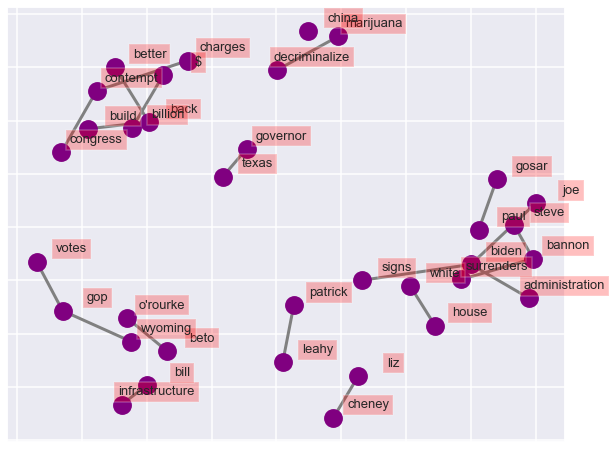

In [47]:
d = bigram_df.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node("china", weight=100)

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

In [4]:
import requests
 
subreddit = 'python'
limit = 1
timeframe = 'month' #hour, day, week, month, year, all
listing = 'top' # controversial, best, hot, new, random, rising, top
 
def get_reddit(subreddit,listing,limit,timeframe):
    try:
        base_url = f'https://www.reddit.com/r/{subreddit}/{listing}.json?limit={limit}&t={timeframe}'
        request = requests.get(base_url, headers = {'User-agent': 'yourbot'})
    except:
        print('An Error Occured')
    return request.json()
 
r = get_reddit(subreddit,listing,limit,timeframe)